In [1]:
!git clone https://github.com/richardyy1188/Pretrain-MLM-and-finetune-on-GLUE-with-fastai.git
%cd Pretrain-MLM-and-finetune-on-GLUE-with-fastai
%pip install -q fastai2 transformers

fatal: destination path 'Pretrain-MLM-and-finetune-on-GLUE-with-fastai' already exists and is not an empty directory.
/content/Pretrain-MLM-and-finetune-on-GLUE-with-fastai


In [0]:
from IPython.core.debugger import set_trace as bk
from pathlib import Path
import pandas as pd
import torch
from torch import nn
from fastai2.text.all import *
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
pretrained_model_name='distilbert-base-cased' # see https://huggingface.co/transformers/pretrained_models.html
hf_tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name)
from _utils.demo_data import load_demo_dataframe
from _utils.hf_transformers_integration import HF_Tokenizer, HF_TextBlock, HFModelWrapper

# 1. Load Data

**Prepare source dataframe**

In [3]:
df = load_demo_dataframe()
df.head()

,text,is_valid
0,"Out of his box the Jack popped his head . The funny , black fringe of whiskers around his face jiggled up and down . His queer , big eyes looked around the store .",False
1,""" Hurray ! "" cried the Jack in the Box . "" We are alone at last and now we can have some fun ! Hurray ! """,False
2,""" Are you sure ? "" asked a Bold Tin Soldier , who stood at the head of a company of his men in a large box .",False
3,""" Am I sure of what ? "" inquired the Jack , as he swung to and fro on the spring which made him pop out of the box .",False
4,""" Are you sure we are alone ? "" went on the Soldier . "" It would be too bad if we should come to life when any one could see us . """,False


**DataLoaders**

In [4]:
db = DataBlock(splitter=ColSplitter(),
              blocks=HF_TextBlock.from_df('text', hf_tokenizer),
              get_x=ColReader('text'),)
""" Note:
If you don't cancel pad first, you will get input with variable number of pad before sentence.
like 'pad ... pad pad I am input x pad .. pad pad'
Which you may cause add wrong position's position embeddings when using transformer architecture
"""
dls = db.dataloaders(df, shuffle_train=False, pad_first=False)
""" Note:
fastai wiil assure data and model are on the same device, so we just need to specify device for dataloaders,
and fastai will infer and move model to that device.
"""
if torch.cuda.is_available(): dls.cuda() 
dls.show_batch(max_n=2)

,text
0,"[CLS] "" Dear Mother : I am so glad you have the sixty - five dollars , for then you will not have to work so hard , and can take a little rest . It was so good of Uncle Jack to send it to you . I feel so much better now that you have this money . You will not have to worry so much . I am working hard myself , but I like it , and I will save all I can and send all I can spare to you . Take good care of the money and do n ' t lose it , for you may never have as much again . I am very lone ##some and wish I could see you , but I know the rest will do you good . With lots of love . "" [SEP]"
1,"[CLS] "" Looks that way , "" replied the fore ##man . "" I guess he must have drunk some water that had a bit of < un ##k > meat in it . You see , "" he went on to the doctor , Mr . Martin and the children , "" we have a lot of wolves and other < un ##k > animals around here . They ' re too < un ##k > to catch in traps or shoot , so we poison ' em by putting a white powder in some meat . Sometimes the wolves will drag a piece of the < un ##k > meat to a spring of water , and they must have done it this time . Then the p ##ony drank the water and it made him sick . "" [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"


# 2. Masked language model objective

## 2.1 MLM objective callback

In [0]:
# https://github.com/huggingface/transformers/blob/1789c7daf1b8013006b0aef6cb1b8f80573031c5/examples/run_language_modeling.py#L179
def mask_tokens(inputs, mask_token_index, vocab_size, special_token_indices, mlm_probability=0.15, ignore_index=-100):
  """ Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original. """
  "ignore_index in nn.CrossEntropy is default to -100, so you don't need to specify ignore_index in loss"
  
  assert len(inputs.shape)==2, "Assume input shape of (batch_size, sequence_length)"
  labels = inputs.clone()
  
  # We sample a few tokens in each sequence for masked-LM training (with probability mlm_probability defaults to 0.15 in Bert/RoBERTa)
  probability_matrix = torch.full(labels.shape, mlm_probability)
  special_tokens_mask = torch.tensor([
    [i in special_token_indices for i in sample] for sample in labels
  ], dtype=torch.bool)
  probability_matrix.masked_fill_(special_tokens_mask, value=0.0)
  mlm_mask = torch.bernoulli(probability_matrix).bool()
  labels[~mlm_mask] = ignore_index  # We only compute loss on masked tokens
  
  # 80% of the time, we replace masked input tokens with mask_token
  mask_token_mask = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & mlm_mask
  inputs[mask_token_mask] = mask_token_index
  
  # 10% of the time, we replace masked input tokens with random word
  replace_token_mask = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & mlm_mask & ~mask_token_mask
  random_words = torch.randint(vocab_size, labels.shape, dtype=torch.long, device=inputs.device)
  inputs[replace_token_mask] = random_words[replace_token_mask]

  # The rest of the time (10% of the time) we keep the masked input tokens unchanged
  return inputs, labels

class MaskedLanguageModel(Callback):
  @delegates(mask_tokens)
  def __init__(self, mask_tok_id, special_tok_ids, vocab_size, **kwargs):
    self.mask_tokens = partial(mask_tokens,
                               mask_token_index=mask_tok_id,
                               special_token_indices=special_tok_ids,
                               vocab_size=vocab_size,
                               **kwargs)

  def begin_batch(self):
    text_indices = self.xb[0]
    masked_inputs, labels = self.mask_tokens(text_indices)
    self.learn.xb, self.learn.yb = (masked_inputs,), (labels,)

## 2.2 Train

epoch,train_loss,valid_loss,accuracy,time
0,5.490578,4.857467,0.039938,01:45
1,3.505973,6.361567,0.006354,01:45
2,2.916482,3.944067,0.044518,01:45
3,2.450524,2.982636,0.063963,01:46
4,2.314176,2.817696,0.068535,01:45


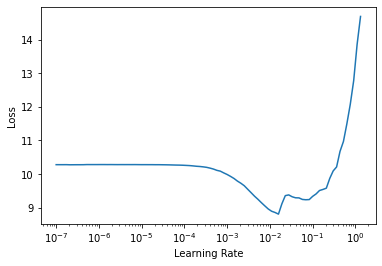

In [6]:
model = nn.Sequential(HFModelWrapper(DistilBertModel.from_pretrained(pretrained_model_name),hf_tokenizer.pad_token_id),
                      nn.Linear(768, hf_tokenizer.vocab_size))

mlm_cb = MaskedLanguageModel(mask_tok_id=hf_tokenizer.mask_token_id, 
                             special_tok_ids=hf_tokenizer.all_special_ids, 
                             vocab_size=hf_tokenizer.vocab_size)
learn = Learner(dls, model,  
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy,
                opt_func=ranger,
                cbs=[mlm_cb])

# help you find the best learning rate for "one cycle learning rate schedule"
# the graph below is the result of learning rate finding
lr, _ = learn.lr_find()

""" !! Note !!
Although the accuracy is not like a pretrained model should achieve, 
but note that we mount an untrained one layer prediction head (output layer). 
"""
""" !! Note !!
to_fp16 give us nan loss, which is something we need to work on. 
"""
learn.fit_one_cycle(5, lr) 

# 3. ELECTRA (replaced token detection objective)

see details on arxiv [ELECTRA: Pre-training Text Encoders as Discriminators Rather Than Generators](https://arxiv.org/abs/2003.10555)

In [0]:
class Electra(nn.Module):
  def __init__(self):
    super().__init__()
    self.generator = nn.Sequential(HFModelWrapper(DistilBertModel(DistilBertConfig(
                                                  vocab_size=hf_tokenizer.vocab_size,
                                                  n_layers=1,
                                  )), pad_id=hf_tokenizer.pad_token_id),
                     nn.Linear(768, hf_tokenizer.vocab_size))
    self.discriminator = nn.Sequential(HFModelWrapper(DistilBertModel.from_pretrained(pretrained_model_name),hf_tokenizer.pad_token_id),
                                      nn.Linear(768, 1))

In [0]:
class ElectraCallback(MaskedLanguageModel):
  run_after=MixedPrecision # ???
  @delegates(MaskedLanguageModel.__init__)
  def __init__(self, electra_model, mask_tok_id, special_tok_ids, vocab_size, loss_weights=(1.0, 50.0), **kwargs):
    super().__init__(mask_tok_id, special_tok_ids, vocab_size, **kwargs)
    assert len(loss_weights)==2, 'loss_weights should contain element 0 and 1 for weight of generator loss and dicriminator loss respectively.'
    store_attr(self, 'electra_model, mask_tok_id, loss_weights')
    """
    This is equivalent of tf.nn.sigmoid_cross_entropy_with_logits, which is a sigmoid layer before cross entropy,
    when value of targes is either 1.0 or 0.0 .
    """
    self.discri_loss_func = nn.BCEWithLogitsLoss()
  
  def begin_fit(self):
    for cb in self.cbs:
      if isinstance(cb, MixedPrecision): self.fp16_cb = cb
  def after_fit(self):
    if hasattr(self, 'fp16_cb'): delattr(self, 'fp16_cb')

  def after_loss(self):
    # prepare discriminator's inputs and labels
    masked_inputs, labels = self.xb[0], self.yb[0] # both (batch size, sequence length)
    masked_pos_mask = masked_inputs == self.mask_tok_id # 1 for masked position, 0 for the others
    pred_toks = self.pred.argmax(dim=-1)
    generated = masked_inputs + masked_pos_mask * pred_toks # use predicted token to fill masked position
    replaced = (masked_pos_mask & (pred_toks != labels))  # is masked token and not equal to predicted
    
    discri_pred = self.electra_model.discriminator(generated).to(dtype=self.pred.dtype) # (bs, seq_len, 1)
    discri_pred = discri_pred.squeeze(-1) # (bs, seq_len)
    if hasattr(self, 'fp16_cb'): discri_pred = to_float(discri_pred)
    discri_loss = self.discri_loss_func(discri_pred, replaced.to(dtype=discri_pred.dtype))
    if hasattr(self, 'fp16_cb'): discri_loss *= self.fp16_cb.loss_scale
    self.learn.loss = torch.stack([self.loss, discri_loss]).matmul(torch.tensor(self.loss_weights, dtype=self.loss.dtype, device=self.loss.device))

    self.learn.model = self.electra_model

  def begin_batch(self):
    super().begin_batch() # -> self.xb, self.yb = (masked_inputs,),(answers,)
    self.learn.model = self.electra_model.generator

epoch,train_loss,valid_loss,accuracy,time
0,11.152092,8.933139,0.011542,01:49
1,20.357895,23.097658,0.015984,01:49
2,19.169250,21.986542,0.020290,01:49
3,18.833910,20.073820,0.030377,01:49
4,18.431017,19.611004,0.033630,01:49


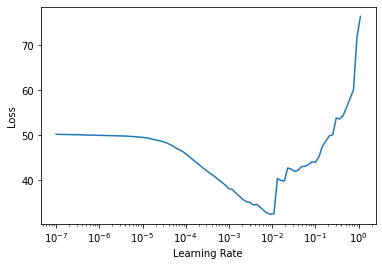

In [9]:
electra_model = Electra()
electra_cb = ElectraCallback(electra_model, 
                             mask_tok_id=hf_tokenizer.mask_token_id, 
                             special_tok_ids=hf_tokenizer.all_special_ids, 
                             vocab_size=hf_tokenizer.vocab_size)
learn = Learner(dls, electra_model,  
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy,
                opt_func=ranger,
                cbs=[electra_cb])

# help you find the best learning rate for "one cycle learning rate schedule"
lr, _ = learn.lr_find()

""" !!Note !!
The loss is very large because Electra scales the discriminator loss by 50.
"""
""" !! Note !!
to_fp16 give us nan loss, which is something we need to work on. 
"""
learn.fit_one_cycle(5, lr)